In [1]:
import aiida

# must execute it in the first place
aiida.load_profile()


In [2]:
from aiida.orm import Code
from aiida.orm import Str, Int, Dict, List, Float
from aiida.engine import calcfunction, WorkChain, ToContext, append_
from aiida.plugins import DataFactory, WorkflowFactory
from itertools import cycle
import os

from aiida.engine import calcfunction, workfunction, submit, run
from aiida.engine import run_get_node
from aiida.orm import load_code, load_node
from ase import io
from tools import wait_for_node_finished
from aiida_alamode.io import load_atoms_bare
from aiida_alamode.io import load_atoms

# load types
StructureData = DataFactory('structure')
FolderData = DataFactory('folder')
SinglefileData = DataFactory('singlefile')
ArrayData = DataFactory('array')
List = DataFactory('list')
TrajectoryData = DataFactory('array.trajectory')


In [3]:
# codeの定義を行う。
from tools.aiida_support import get_or_create_local_computer, get_or_create_code
from os.path import expanduser
import os


In [4]:
home = expanduser("~")
work_directory = os.path.join(home, 'aiida')
computer_local = get_or_create_local_computer(work_directory, 'localhost')
print(computer_local)
code = get_or_create_code('alamode.displace_pf',
                          computer_local,
                          '/home/max/Documents/alamode/displace.py')
code_displace_pf = code
code = get_or_create_code('alamode.displace_random',
                          computer_local,
                          '/home/max/Documents/alamode/displace.py')
code_displace_random = code
code = get_or_create_code('alamode.lammps',
                          computer_local,
                          '/usr/bin/lammps')

code_lammps_name = Str('alamode.lammps@localhost')

code = get_or_create_code('alamode.extract',
                          computer_local,
                          '/home/max/Documents/alamode/tools/extract.py')
code_extract = code
code_extract_name = Str('alamode.extract@localhost')


code_displace_random, code_displace_pf, code_lammps_name


localhost (localhost), pk: 2


(<Code: Remote code 'alamode.displace_random' on localhost, pk: 2385, uuid: c893e5e1-c9ed-4d33-91eb-b4c8c2848412>,
 <Code: Remote code 'alamode.displace_pf' on localhost, pk: 2384, uuid: 1ded5557-bd21-4ebc-b2b5-f524c5ab4e25>,
 <Str: uuid: 57fb06a3-7728-4c02-bdca-97a9f2ea4be3 (unstored) value: alamode.lammps@localhost>)

In [5]:
import json
with open("setting.json") as f:
    _dic = json.load(f)
print(_dic)
CWD = _dic["CWD"]
_path = os.path.abspath(CWD)
os.makedirs(_path, exist_ok=True)
_path


{'CWD': 'run35'}


'/home/max/Documents/aiida-alamode_public/example/run35'

In [6]:

from os.path import expanduser
from tools import NodeBank


# 再実行時に作成したノードを用いるためにnodebankを使う。
g_force = False
nodebank = NodeBank(_path, force=g_force)


In [7]:
g_prefix = nodebank.load('cubic_prefix')
g_norder = nodebank.load('cubic_norder')
g_prefix, g_norder


(<Str: uuid: 365abe8c-3a31-4aa7-b7cf-5da1f911303b (pk: 3694) value: cubic>,
 <Int: uuid: 79b9b510-e505-4397-8faf-21ded8dac26f (pk: 3693) value: 2>)

In [8]:
g_cwd = nodebank.load(f"{g_prefix.value}_cwd")  # ファイル保存directory
g_superstructure = nodebank.load("superstructure")  # 使用する長周期構造StructureData

g_file_format = nodebank.load("format")  # lammpsの位置フォーマット
g_file_format, g_cwd


(<Str: uuid: 974b0887-fc03-4224-aee5-655d8839f901 (pk: 3600) value: LAMMPS>,
 <Str: uuid: edaf2272-df44-4202-816b-4e3d50f91415 (pk: 3696) value: /home/max/Documents/aiida-alamode_public/example/run35/Si8_2x0x0x0x2x0x0x0x2_cubic>)

## for LAMMPS

In [9]:
key = "format"
g_format = nodebank.load_or_dump(key, Str("LAMMPS"))  # alamodeのファイルオプションの定義


debug, node uuid: 9025224a-f83b-45d4-a4e3-71bf379528c8 (unstored) value: LAMMPS
debug, load uuid: 974b0887-fc03-4224-aee5-655d8839f901 (pk: 3600) value: LAMMPS


In [10]:
from aiida_lammps.tests.utils import (
    get_or_create_local_computer, get_or_create_code)
from aiida_lammps.tests.utils import lammps_version


In [11]:
computer_local = get_or_create_local_computer('work_directory', 'localhost')
code_lammps_force = get_or_create_code('lammps.force', computer_local, 'lammps')


In [12]:
code_lammps_force_name = Str(code_lammps_force.label+"@"+'localhost')



In [13]:
g_mag = nodebank.load_or_dump(f"{g_prefix.value}_mag", Float(0.04))


debug, node uuid: 3984a4c5-59fc-42d7-9289-cf91f8c1e9bd (unstored) value: 0.04
debug, load None
debug, force dump


In [14]:

displacement_patterns = nodebank.load(f'{g_prefix.value}_pattern')
displacement_patterns[1]


[[[0, [1.0, 0.0, 0.0], 'Cartesian']],
 [[0, [1.0, 0.0, 0.0], 'Cartesian'], [0, [0.0, 1.0, 0.0], 'Cartesian']],
 [[0, [1.0, 0.0, 0.0], 'Cartesian'], [2, [1.0, 0.0, 0.0], 'Cartesian']],
 [[0, [1.0, 0.0, 0.0], 'Cartesian'], [2, [-1.0, 0.0, 0.0], 'Cartesian']],
 [[0, [-1.0, 0.0, 0.0], 'Cartesian'], [2, [-1.0, 0.0, 0.0], 'Cartesian']],
 [[0, [1.0, 0.0, 0.0], 'Cartesian'], [2, [0.0, 1.0, 0.0], 'Cartesian']],
 [[0, [1.0, 0.0, 0.0], 'Cartesian'], [2, [0.0, -1.0, 0.0], 'Cartesian']],
 [[0, [-1.0, 0.0, 0.0], 'Cartesian'], [2, [0.0, 1.0, 0.0], 'Cartesian']],
 [[0, [-1.0, 0.0, 0.0], 'Cartesian'], [2, [0.0, -1.0, 0.0], 'Cartesian']],
 [[0, [1.0, 0.0, 0.0], 'Cartesian'], [4, [1.0, 0.0, 0.0], 'Cartesian']],
 [[0, [1.0, 0.0, 0.0], 'Cartesian'], [4, [-1.0, 0.0, 0.0], 'Cartesian']],
 [[0, [-1.0, 0.0, 0.0], 'Cartesian'], [4, [1.0, 0.0, 0.0], 'Cartesian']],
 [[0, [1.0, 0.0, 0.0], 'Cartesian'], [4, [0.0, 0.0, 1.0], 'Cartesian']],
 [[0, [1.0, 0.0, 0.0], 'Cartesian'], [4, [0.0, 0.0, -1.0], 'Cartesian']],
 [[

In [15]:
g_action = "random"

if g_action == "pf":

    #codename = "alamode.displace_pf@tutor"
    #code = Code.get_from_string(codename)
    code = code_displace_pf

    builder = code.get_builder()
    builder.format = g_format
    builder.cwd = Str(os.path.join(g_cwd.value, f"{g_prefix.value}_suggest_pf"))
    builder.prefix = g_prefix
    builder.structure_org = g_superstructure
    builder.mag = g_mag
    builder.pattern = displacement_patterns

    g_displacefuture = nodebank.load_code_or_wait_for_node(f"{g_prefix.value}_displace_pf", builder)


elif g_action == "random":

    g_num_disp = nodebank.dump(f"{g_prefix.value}_num_disp", Int(40))

    code = code_displace_random

    builder = code.get_builder()
    builder.format = g_format
    builder.cwd = Str(os.path.join(g_cwd.value, f"{g_prefix.value}_suggest_random"))
    builder.prefix = g_prefix
    builder.structure_org = g_superstructure
    builder.mag = g_mag
    builder.num_disp = g_num_disp
    

    g_displacefuture = nodebank.load_code_or_wait_for_node(f"{g_prefix.value}_suggest_random", builder)

else:
    raise ValueError("unknown action")


None
uuid: bda751c3-8b1e-405d-b8c9-337cdc05e788 (pk: 3710) (aiida.calculations:alamode.displace_random)
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
True True
0:00:12.556987


In [16]:
g_displacefuture.outputs.retrieved.list_object_names()


['_aiidasubmit.sh',
 '_scheduler-stderr.txt',
 '_scheduler-stdout.txt',
 'cubic01.lammps',
 'cubic02.lammps',
 'cubic03.lammps',
 'cubic04.lammps',
 'cubic05.lammps',
 'cubic06.lammps',
 'cubic07.lammps',
 'cubic08.lammps',
 'cubic09.lammps',
 'cubic10.lammps',
 'cubic11.lammps',
 'cubic12.lammps',
 'cubic13.lammps',
 'cubic14.lammps',
 'cubic15.lammps',
 'cubic16.lammps',
 'cubic17.lammps',
 'cubic18.lammps',
 'cubic19.lammps',
 'cubic20.lammps',
 'cubic21.lammps',
 'cubic22.lammps',
 'cubic23.lammps',
 'cubic24.lammps',
 'cubic25.lammps',
 'cubic26.lammps',
 'cubic27.lammps',
 'cubic28.lammps',
 'cubic29.lammps',
 'cubic30.lammps',
 'cubic31.lammps',
 'cubic32.lammps',
 'cubic33.lammps',
 'cubic34.lammps',
 'cubic35.lammps',
 'cubic36.lammps',
 'cubic37.lammps',
 'cubic38.lammps',
 'cubic39.lammps',
 'cubic40.lammps',
 'displace_random.out']

In [17]:
g_displaced_structures = g_displacefuture.outputs.displaced_structures
g_displaced_structures


<TrajectoryData: uuid: 4f8738e1-496b-4533-8646-94c10f3f8d90 (pk: 3714)>

# load tersoff potential

In [18]:
import json
potentialfile = "lammps_input/potentials/tersoff.json"

with open(potentialfile, "r") as f:
    potential_dict = json.load(f)
lammps_potential = DataFactory("lammps.potential")(
    type=potential_dict["pair_style"], data=potential_dict["potential_dict"]
)
lammps_potential


<EmpiricalPotential: uuid: 3a50ccd8-393e-4f9a-b033-7abe74821491 (unstored)>

In [19]:
code_lammps_force_name


<Str: uuid: e336f124-c66e-4d4d-a5ae-c4d2a14bffc9 (unstored) value: lammps.force-lammps-localhost@localhost>

# execution option

In [20]:
lammps_parameters = DataFactory('dict')(dict={
    'lammps_version': lammps_version(),
    'output_variables': ["temp", "etotal", "pe", "ke"],
    'thermo_keywords': []
})
meta_options = {
    "resources": {
        "num_machines": 1,
        "num_mpiprocs_per_machine": 1}
}


# run all the displacements

In [21]:
Code.get_from_string(code_lammps_force_name.value)


<Code: Remote code 'lammps.force-lammps-localhost' on localhost, pk: 2389, uuid: 74769bd2-a4ae-4667-8de0-ca33c93edf5b>

In [22]:
alldisp_lammps_WorkChain = WorkflowFactory("alamode.force_simulator_lammps")


In [23]:
g_prefix


<Str: uuid: 365abe8c-3a31-4aa7-b7cf-5da1f911303b (pk: 3694) value: cubic>

In [24]:
inputs = {"structures": g_displaced_structures,
          "parameters": lammps_parameters,
          "code_string":  code_lammps_force_name,
          #"cwd": Str(os.path.join(g_cwd.value, "cubic_all_run")),
          "prefix": g_prefix,
          'potential': lammps_potential}



In [25]:
# It will take 30 min. for GaN222.


In [26]:
from datetime import datetime
starttime = datetime.now()

lammps_all = nodebank.load(f"{g_prefix.value}_all_lammps", raise_error=False)
if lammps_all is None:
    lammps_all = submit(alldisp_lammps_WorkChain, **inputs)
    print(lammps_all)
    wait_for_node_finished(lammps_all, 5)
    print(lammps_all.is_finished_ok)
    if lammps_all.is_finished_ok:
        nodebank.dump(f"{g_prefix.value}_all_lammps", lammps_all)
endtime = datetime.now()
print(endtime-starttime)


uuid: 635d98da-6009-43e7-8381-26390944e4f1 (pk: 3720) (aiida.workflows:alamode.force_simulator_lammps)
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
wait another 5 sec.
True True
True
0:00:45.306000


In [27]:
if False:
    # too big to show
    pk = lammps_all.pk
    print(pk)
    !verdi node graph generate $pk
    from wand.image import Image as WImage
    filename = f"{pk}.dot.pdf"
    img = WImage(filename=filename)
    display(img)

# extract

In [28]:
g_target_dict = lammps_all.outputs.displacement_and_forces

In [29]:
g_superstructure


<StructureData: uuid: 1eb2842f-97b4-4aef-8620-145bf24e0619 (pk: 3581)>

In [30]:
code_extract = Code.get_from_string(code_extract_name.value)
code_extract


<Code: Remote code 'alamode.extract' on localhost, pk: 2387, uuid: 9308168e-ba1c-41f4-83a4-af404b795b85>

In [31]:
builder = code_extract.get_builder()
builder.format = g_format
builder.structure_org = g_superstructure
# builder.cwd = Str(os.path.join(g_cwd.value, f"{g_prefix.value}_extract"))
builder.prefix = g_prefix
builder.displacement_and_forces = g_target_dict
# builder.parameters = Dict(dict={"LAMMPS":{"lammps-style":"atomic"}})


In [32]:
g_extract = submit(builder)
wait_for_node_finished(g_extract)


wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
wait another 2 sec.
True True


In [33]:
nodebank.dump(f"{g_prefix.value}_extract", g_extract)


<CalcJobNode: uuid: 556d0038-f4aa-4923-ac92-ed3bc6a4d726 (pk: 3969) (aiida.calculations:alamode.extract)>

In [34]:
print("done")


done


3969
Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 3969.dot.pdf


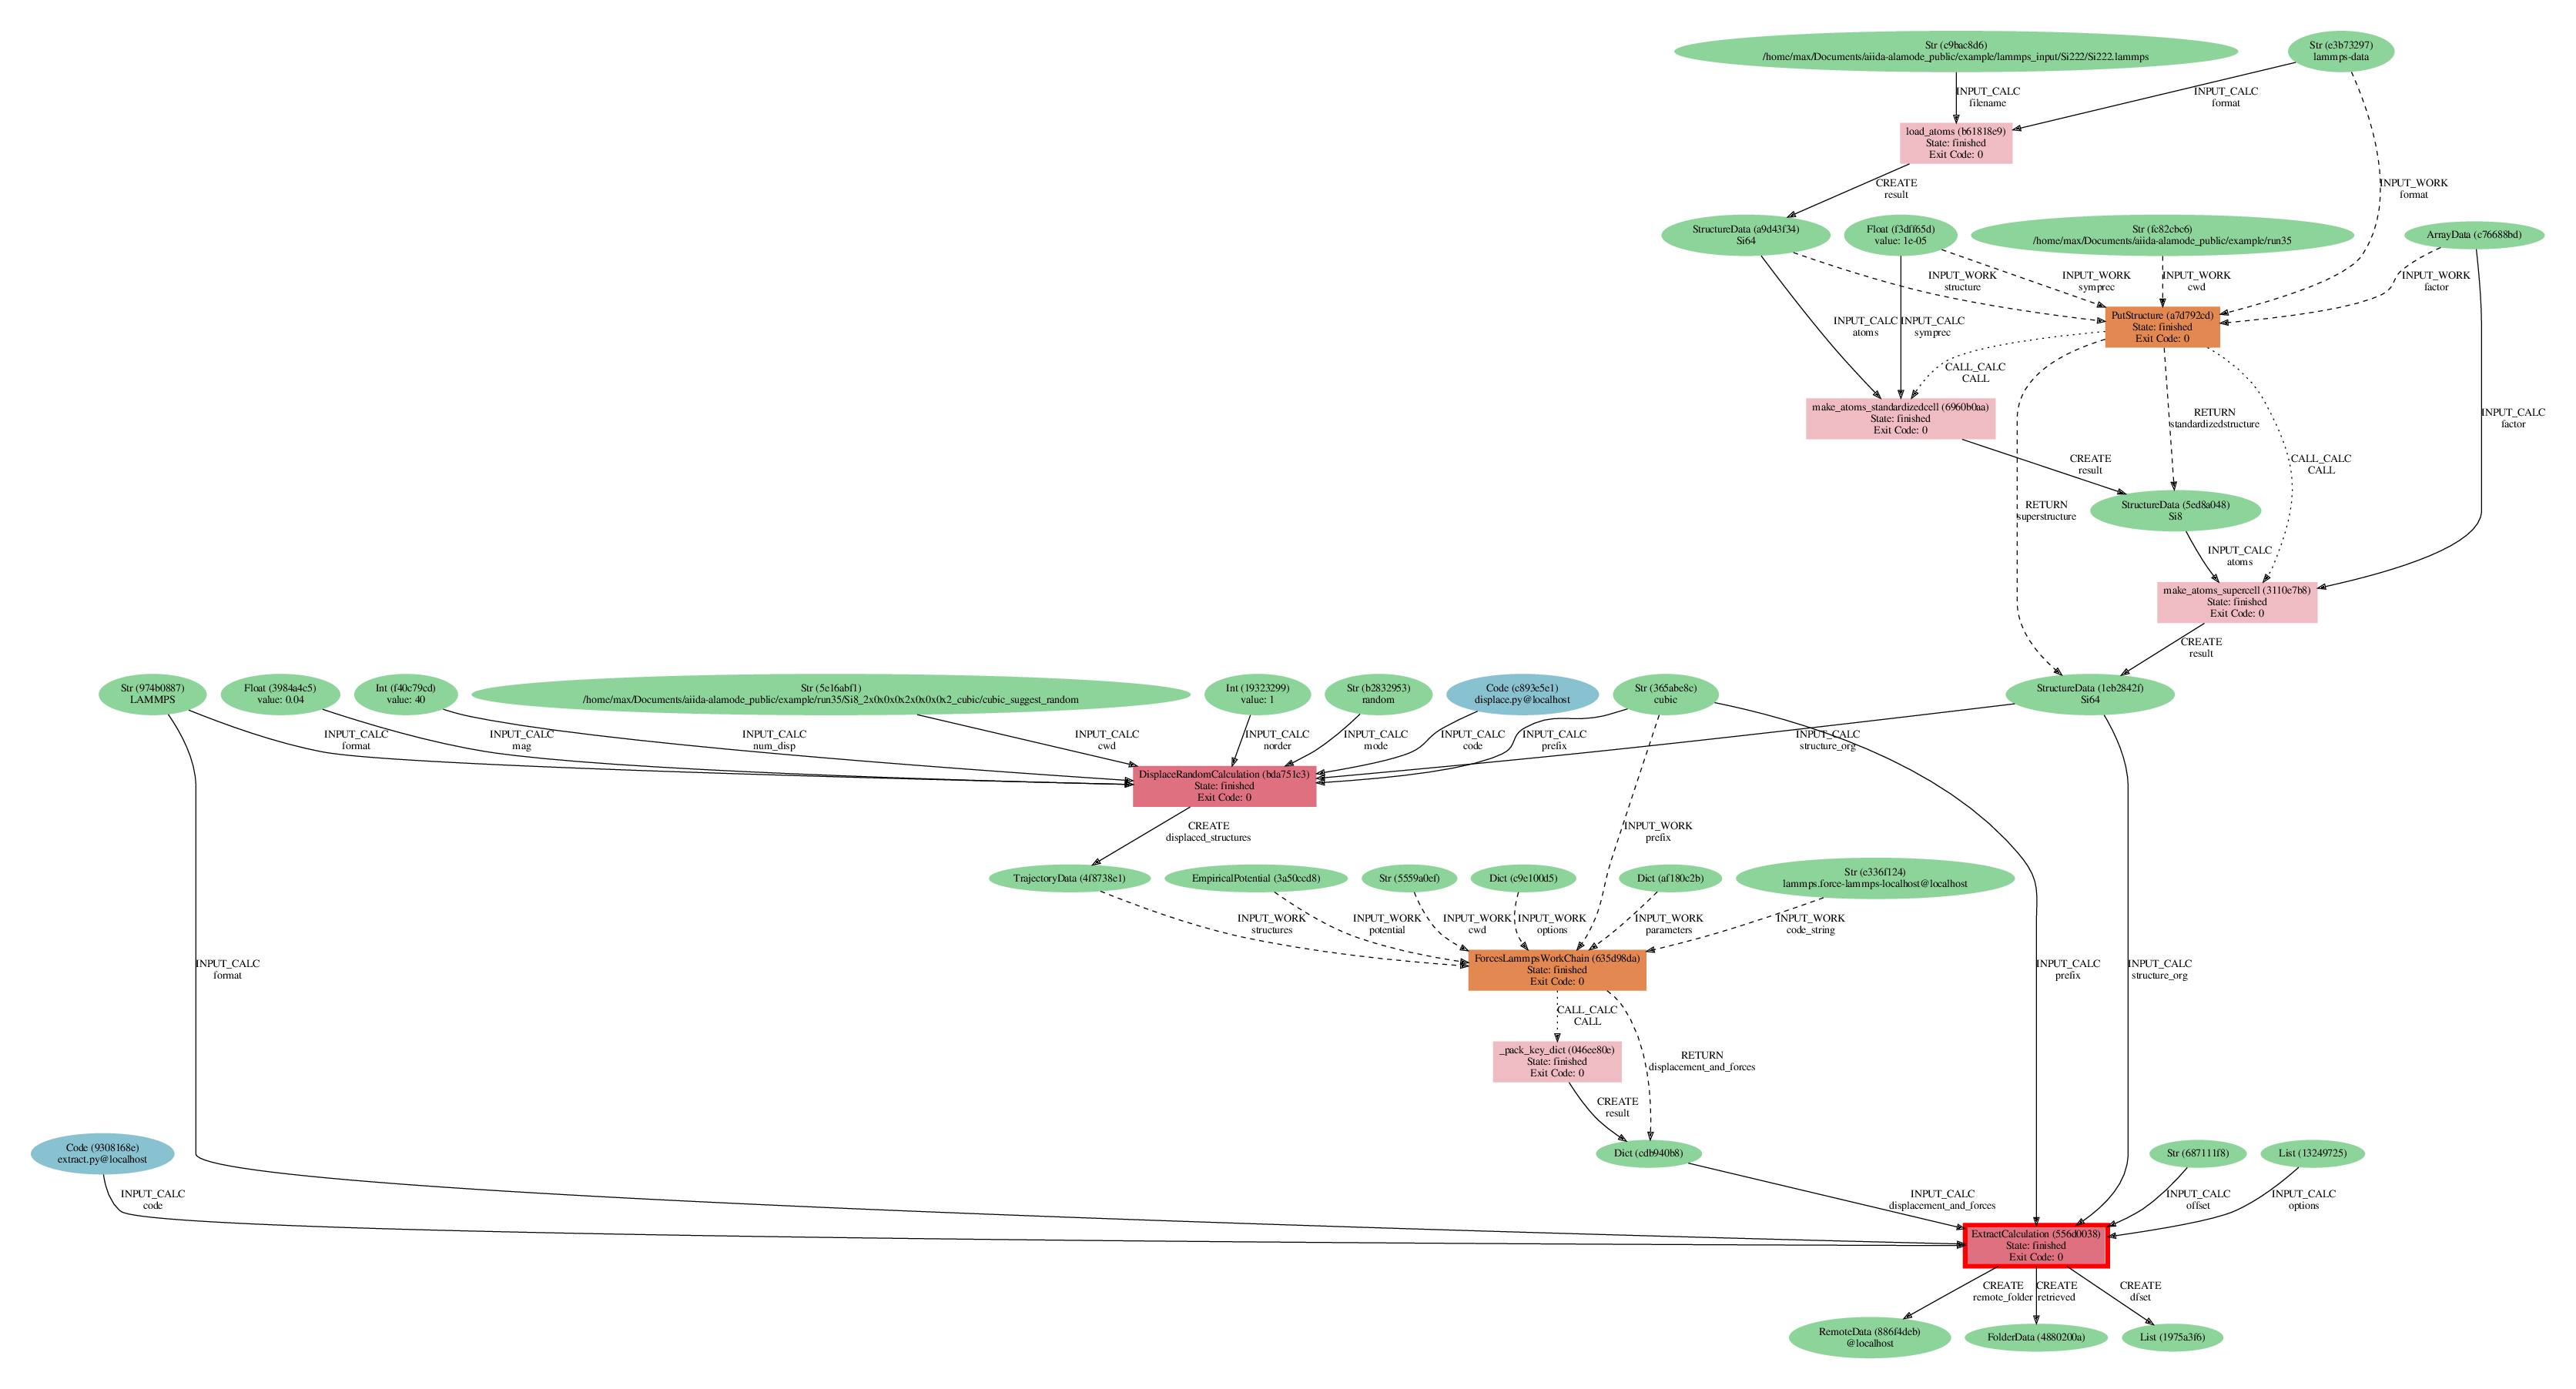

In [35]:
g_graph=True
if g_graph:
    
    pk = g_extract.pk
    print(pk)
    !verdi node graph generate $pk
    from wand.image import Image as WImage
    filename = f"{pk}.dot.pdf"
    img = WImage(filename=filename)
    display(img)
